In [ ]:
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:

data = pd.read_csv('IT_sector.csv')
print(data.head())
print(data.info())
print(data.describe())

         Date      Open      High       Low     Close   Shares Traded   \
0  01-DEC-2017  11123.60  11180.40  10930.95  10948.50      15744634.0   
1  04-DEC-2017  11007.95  11138.10  10901.10  11081.65      28758345.0   
2  05-DEC-2017  11079.35  11121.85  11005.90  11025.40      22390897.0   
3  06-DEC-2017  11024.55  11099.05  11006.20  11074.90      26426388.0   
4  07-DEC-2017  11075.55  11178.80  11057.45  11163.45      25529596.0   

   Turnover (Cr)  
0         766.04  
1        1619.53  
2        1209.54  
3        1170.90  
4        1338.80  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1900 non-null   object 
 1   Open            1900 non-null   float64
 2   High            1900 non-null   float64
 3   Low             1900 non-null   float64
 4   Close           1900 non-null   float64
 5   Shares Traded  

In [ ]:

data.columns = data.columns.str.strip()  # Remove spaces from column names
print(data.isna().sum())
# Remove spaces from string data in the entire DataFrame
df = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df.fillna(0, inplace=True)  # Fill NaN values with 0

Date             0
Open             0
High             0
Low              0
Close            0
Shares Traded    2
Turnover (Cr)    2
dtype: int64


/tmp/ipython-input-2296208926.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [ ]:

data['returns'] = data['Close'].pct_change()
data['returns']=data['returns']*100
data['volatility'] = data['returns'].rolling(window=15).std()   #To get the annualized volatility
data['volatility'].fillna(0, inplace=True)

/tmp/ipython-input-1235686402.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['volatility'].fillna(0, inplace=True)


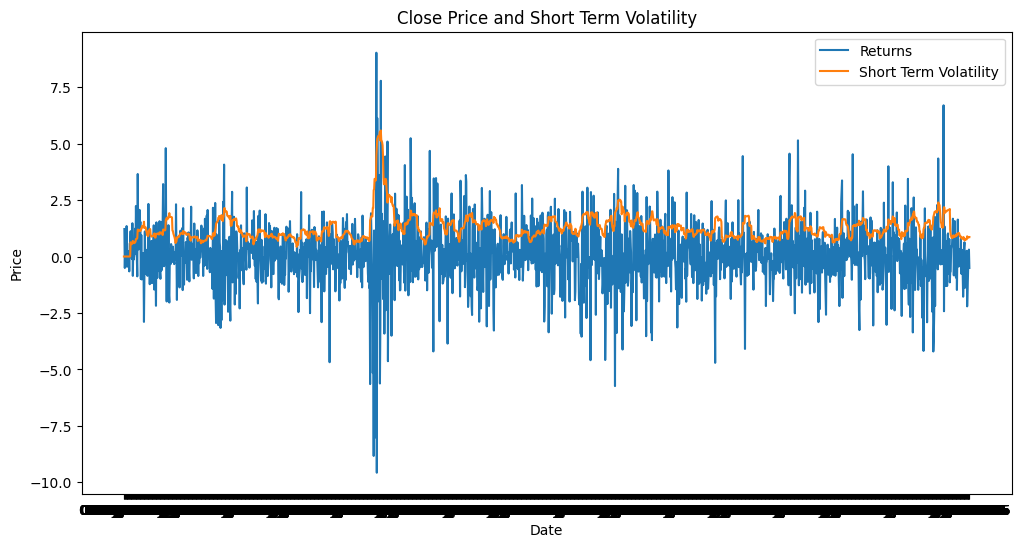

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['returns'], label='Returns')
plt.plot(data['Date'], data['volatility'], label='Short Term Volatility')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close Price and Short Term Volatility')
plt.legend()
plt.show()

In [ ]:
numeric_data = data.select_dtypes(include=["int64", "float64"]) #Only selcting the data which is numeric

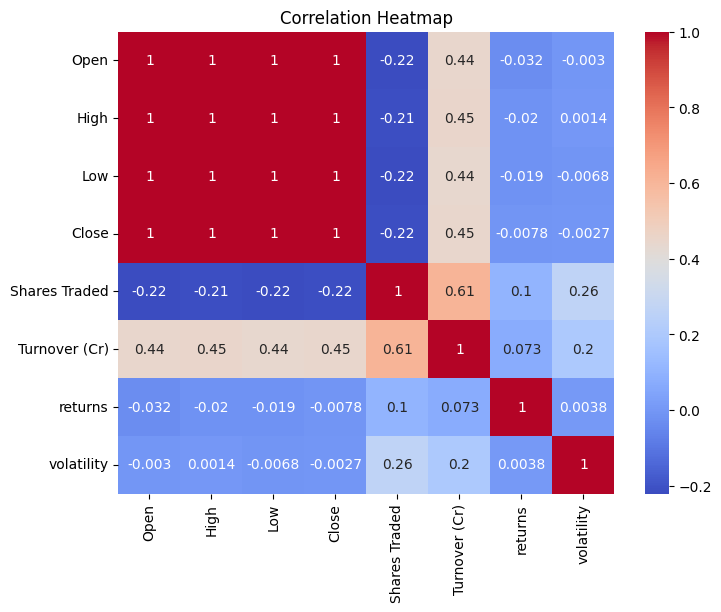

In [ ]:

plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
#convert the data into date time then create a date filter
data['Date'] = pd.to_datetime(data['Date'])
prediction = data.loc[(data['Date'] > datetime(2018,1,1)) & (data['Date'] < datetime(2024,1,1))]

/tmp/ipython-input-4099536068.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


<h2> Prepare the Sequencial Model </h2>

In [ ]:
market_volatility = data['volatility'].values.reshape(-1,1) #convert to numpy array
train_len = int(np.ceil(len(market_volatility))*0.9) # 90 % of total data for training

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(market_volatility)
training_data = scaler.fit_transform(market_volatility[:train_len].reshape(-1,1))

In [ ]:
X_train, y_train = [],[]

window = 30
#Sliding windwo for the volatility a month
for i in range(window, len(training_data)):
    X_train.append(training_data[i-window:i,0])
    y_train.append(training_data[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  #Neural networks, especially LSTMs, expect input data in this 3D format: (samples, time_steps, features)




In [ ]:
#Build the model
model = keras.models.Sequential()

#First layer
model.add(keras.layers.LSTM(512, return_sequences=True, activation="relu", input_shape=(X_train.shape[1],1)))

#Second layer
model.add(keras.layers.LSTM(512,activation="relu", return_sequences=True))

#Third layer (Dropout)
model.add(keras.layers.Dropout(0.5))

#fourth layer (LSTM) - Changed from Dense
model.add(keras.layers.LSTM(256, activation="relu", return_sequences=True))

#fifth layer (Dropout)
model.add(keras.layers.Dropout(0.5))

#Sixth layer (LSTM)
model.add(keras.layers.LSTM(128,activation="relu",return_sequences=False)) #The last of the lstm layer should have the return_sequence = False

#Seventh layer (Dropout)
model.add(keras.layers.Dropout(0.2)) # Reduced dropout

#Eighth layer (Dense)
model.add(keras.layers.Dense(1))


model.summary()
model.compile(optimizer="adam", loss="mae", metrics=[keras.metrics.RootMeanSquaredError()])

# training the model
training  = model.fit(X_train, y_train, batch_size=32, epochs=20)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 512)        │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 512)        │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 256)        │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,136,577 (15.78 MB)

 Trainable params: 4,136,577 (15.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - loss: 0.5320 - root_mean_squared_error: 0.9190
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 0.3405 - root_mean_squared_error: 0.5368
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.2970 - root_mean_squared_error: 0.4524
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - loss: 0.2639 - root_mean_squared_error: 0.4339
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - loss: 0.2524 - root_mean_squared_error: 0.4725
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 0.2347 - root_mean_squared_error: 0.3548
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - loss: 0.2197 - root_mean_squared_error: 0.3391
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.2380 - root_mean_squared_error: 0.3670
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.2090 - root_mean_squared_error: 0.3370
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 0.2065 - root_mean_squared_error: 0.3179
Epoch 11/

In [ ]:
#Preparing for the test data
test_data = scaled_data[train_len-window:] # Use the 'window' variable here
X_test, y_test = [],[]

for i in range(window, len(test_data)):
    X_test.append(test_data[i-window:i,0])
    y_test.append(test_data[i,0])

X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step


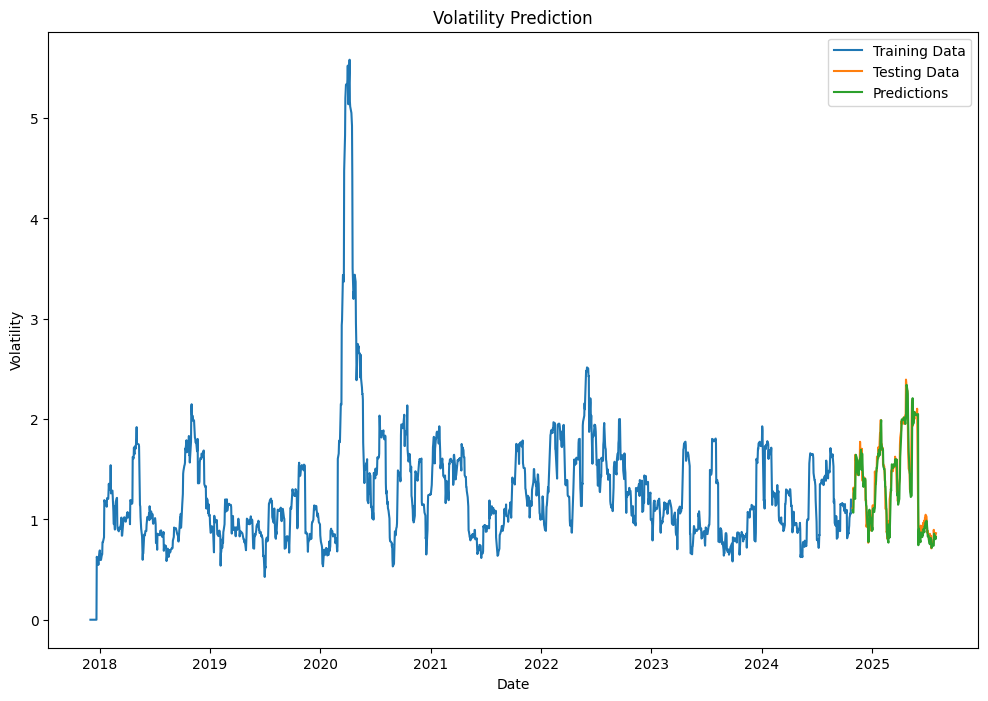

In [ ]:
# make prediction
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

#plotting data
train = data[:train_len]
test = data[train_len:]

test = test.copy()
test['Predictions'] = predictions

plt.figure(figsize=(12,8))
plt.plot(train['Date'], train['volatility'], label='Training Data')
plt.plot(test['Date'], test['volatility'], label='Testing Data')
plt.plot(test['Date'], test['Predictions'], label='Predictions')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Volatility Prediction')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model

test_loss, test_rmse = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - loss: 0.1497 - root_mean_squared_error: 0.2377
Test Loss: 0.1465
Test RMSE: 0.2554


<h2> seq2seq can be used to improve lstm

In [ ]:
#save the model
model.save('volatility_prediction_model.h5')

In [ ]:
%pip install gluonts torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.7 MB/s eta 0:00:00


In [ ]:
# implement the transformer model

import numpy as np
import keras
from keras import layers
# Removed n_classes as this is a regression problem
# n_classes = len(np.unique(y_train))

# Import necessary modules from transformers for TimeSeriesTransformerModel
# Corrected import to use TimeSeriesTransformerModel from transformers
from transformers import TimeSeriesTransformerModel, TimeSeriesTransformerConfig
import torch # Ensure torch is imported

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res


def build_model(
    input_shape, # This will be the sequence length and number of features
    head_size, # Corresponds to d_model in transformers
    num_heads,
    ff_dim, # Corresponds to dim_feedforward in transformers
    num_transformer_blocks, # Corresponds to num_encoder_layers and num_decoder_layers in transformers
    mlp_units, # Used for the final MLP layer in this custom build
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x) # Use GlobalAveragePooling1D

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer for regression
    outputs = layers.Dense(1)(x)

    # Using a custom Keras Model with the transformer_encoder blocks
    # The TimeSeriesTransformerModel from transformers is more for sequence-to-sequence tasks
    # Let's stick to the custom Keras model with the transformer_encoder blocks for this regression task
    model = keras.Model(inputs, outputs)

    return model

In [ ]:
# Build and compile the Keras model with transformer encoder blocks

input_shape = X_train.shape[1:]

trns_model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)


trns_model.compile(
    loss="mse",  # Changed loss to Mean Squared Error for regression
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae", keras.metrics.RootMeanSquaredError()], # Added MAE and RMSE as metrics
)
trns_model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

trns_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
)

trns_model.evaluate(X_test, y_test, verbose=1)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      7,169 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 30, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 1)     │          2 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 1)     │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 4)     │          8 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 4)     │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 1)     │          5 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 1)     │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      7,169 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 30, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ dropout_7[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 1)     │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 30, 4)     │          8 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 30, 4)     │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 30, 1)     │          5 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 30, 1)     │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 32,841 (128.29 KB)

 Trainable params: 32,841 (128.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 459ms/step - loss: 2.6068 - mae: 1.1423 - root_mean_squared_error: 1.6135 - val_loss: 1.0616 - val_mae: 0.8865 - val_root_mean_squared_error: 1.0304
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 410ms/step - loss: 1.4921 - mae: 0.8975 - root_mean_squared_error: 1.2200 - val_loss: 0.8147 - val_mae: 0.7896 - val_root_mean_squared_error: 0.9026
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 429ms/step - loss: 1.7938 - mae: 0.8808 - root_mean_squared_error: 1.3352 - val_loss: 0.6506 - val_mae: 0.7110 - val_root_mean_squared_error: 0.8066
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - loss: 1.3955 - mae: 0.7956 - root_mean_squared_error: 1.1797 - val_loss: 0.5403 - val_mae: 0.6442 - val_root_mean_squared_error: 0.7350
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - loss: 0.9337 - mae: 0.6912 - root_mean_squared_error: 0.9654 - val_loss: 0.4678 - val_mae: 0.5916 - val_root_mean_squared_error: 0.6839
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 393ms

[0.2724851369857788, 0.4186413884162903, 0.5220010876655579]

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


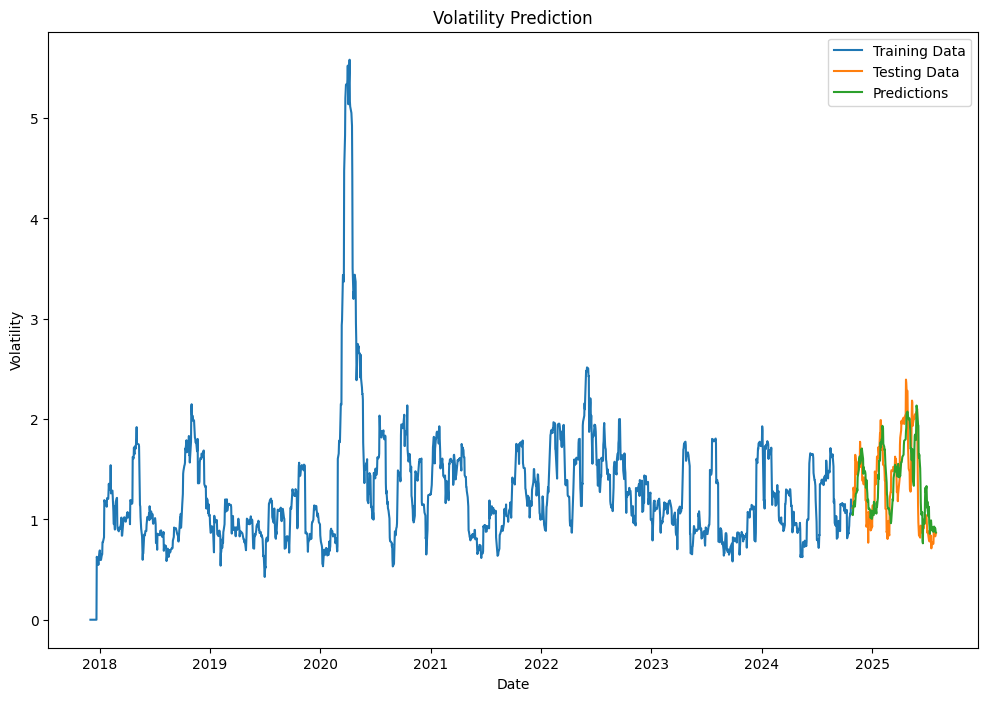

In [ ]:
# make prediction
# Reshape X_test to match the model's expected input shape (samples, 30, 1)
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], window, 1)) # Use the 'window' variable defined earlier

predictions = trns_model.predict(X_test_reshaped)
predictions = scaler.inverse_transform(predictions)

#plotting data
train = data[:train_len]
test = data[train_len:]

test = test.copy()
test['Predictions'] = predictions

plt.figure(figsize=(12,8))
plt.plot(train['Date'], train['volatility'], label='Training Data')
plt.plot(test['Date'], test['volatility'], label='Testing Data')
plt.plot(test['Date'], test['Predictions'], label='Predictions')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Volatility Prediction')
plt.legend()
plt.show()

In [ ]:
# Evaluate the transformer model

test_loss, test_mae, test_rmse = trns_model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss (MSE): {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2141 - mae: 0.3698 - root_mean_squared_error: 0.4564
Test Loss (MSE): 0.2725
Test MAE: 0.4186
Test RMSE: 0.5220


In [ ]:
trns_model.save('volatility_prediction_transformer_model.h5')

Compairing the Test RMSE and Test Loss, LSTM model performance is better.

In [ ]:
#. Run actual VMD code
u, u_hat, omega = VMD(data['volatility'].iloc[1:31], alpha, tau, K, DC, init, tol)

NameError: name 'VMD' is not defined

In [ ]:
for i in range(K):
    plt.plot(u[i])
    plt.show()

In [ ]:
plt.plot(data['volatility'].iloc[:30])
plt.show()
v=0
for i in range(K):
  v+=u[i]
plt.plot(v)
plt.show()

In [ ]:
""" Using AIC/BIC method to find the optimal number of modes (K) """
import numpy as np
import matplotlib.pyplot as plt
from vmdpy import VMD

origninal_signal = data['volatility'].iloc[:30]

# Function to calculate AIC and BIC
def calculate_aic_bic(original_signal, reconstructed_signal, K):
    N = len(original_signal)
    # Calculate the residual error (reconstruction error)
    residual = original_signal - reconstructed_signal
    # Log-likelihood assuming Gaussian distribution for the residuals
    log_likelihood = -0.5 * np.sum(residual**2)

    # AIC and BIC calculation
    aic = 2*K - 2*log_likelihood
    bic = np.log(N)*K - 2*log_likelihood

    return aic, bic

# Example Signal (replace with your actual signal data)
signal = np.sin(2 * np.pi * 1 * np.linspace(0, 1, 100)) + 0.5 * np.sin(2 * np.pi * 3 * np.linspace(0, 1, 100))

# Try different values of K and calculate AIC/BIC
K_values = range(1, 10)  # Test for different K values
aic_values = []
bic_values = []
for K in K_values:
    # Decompose the signal using VMD
    modes, u_hat, omega = VMD(signal, K=K, alpha=2000, tau=0.0, DC=0, init=1, tol=1e-7)

    # Reconstruct the signal from the modes
    reconstructed_signal = np.sum(modes, axis=0)

    # Calculate AIC and BIC
    aic, bic = calculate_aic_bic(signal, reconstructed_signal, K)
    aic_values.append(aic)
    bic_values.append(bic)

# Plot AIC and BIC values to find the optimal K
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K_values, aic_values, marker='o', color='b')
plt.title("AIC vs K")
plt.xlabel("Number of Modes (K)")
plt.ylabel("AIC")

plt.subplot(1, 2, 2)
plt.plot(K_values, bic_values, marker='o', color='r')
plt.title("BIC vs K")
plt.xlabel("Number of Modes (K)")
plt.ylabel("BIC")

plt.tight_layout()
plt.show()

# Print out the optimal K based on AIC and BIC
optimal_K_aic = K_values[np.argmin(aic_values)]
optimal_K_bic = K_values[np.argmin(bic_values)]

print(f"Optimal K based on AIC: {optimal_K_aic}")
print(f"Optimal K based on BIC: {optimal_K_bic}")


In [ ]:
""" Getting K based on minimum reconstructional error method """
import numpy as np
import matplotlib.pyplot as plt
from vmdpy import VMD

original_signal = data['volatility'].iloc[:30]

# Function to calculate reconstruction error (Mean Squared Error)
def calculate_reconstruction_error(original_signal, reconstructed_signal):
    # Calculate Mean Squared Error (MSE)
    mse = np.mean((original_signal - reconstructed_signal) ** 2)
    return mse

# Example Signal (replace with your actual signal data)
signal = np.sin(2 * np.pi * 1 * np.linspace(0, 1, 100)) + 0.5 * np.sin(2 * np.pi * 3 * np.linspace(0, 1, 100))

# Try different values of K and calculate reconstruction error
K_values = range(1, 10)  # Test for different K values
mse_values = []
for K in K_values:
    # Decompose the signal using VMD
    modes, u_hat, omega = VMD(signal, K=K, alpha=2000, tau=0.0, DC=0, init=1, tol=1e-7)

    # Reconstruct the signal from the modes
    reconstructed_signal = np.sum(modes, axis=0)

    # Calculate the reconstruction error (MSE)
    mse = calculate_reconstruction_error(signal, reconstructed_signal)
    mse_values.append(mse)

# Plot MSE values to find the optimal K
plt.plot(K_values, mse_values, marker='o', color='b')
plt.title("Reconstruction Error (MSE) vs K")
plt.xlabel("Number of Modes (K)")
plt.ylabel("Reconstruction Error (MSE)")
plt.show()

# Find the optimal K (minimum reconstruction error)
optimal_K = K_values[np.argmin(mse_values)]
print(f"Optimal K based on reconstruction error: {optimal_K}")


Both of the approaches show that optimal K is 2

In [ ]:
import math
import torch
import torch.nn as nn

class LSTMCell(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Linear layers for forget gate, input gate, output gate, and cell gate
        # The input size to each gate should be input_size + hidden_size
        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size, bias=True)
        self.forget_gate_activation = nn.Sigmoid()

        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size, bias=True)
        self.input_gate_activation = nn.Sigmoid()

        self.output_gate = nn.Linear(input_size + hidden_size, hidden_size, bias=True)
        self.output_gate_activation = nn.Sigmoid()

        self.cell_gate = nn.Linear(input_size + hidden_size, hidden_size, bias=True)
        self.cell_gate_activation = nn.Tanh()

    def forward(self, h_prev: torch.Tensor, c_prev: torch.Tensor, x: torch.Tensor):
        """
        Forward pass for the LSTM cell.
        """
        # Concatenate h_prev (hidden state) and x (input) to pass through gates
        combined = torch.cat((h_prev, x), dim=1)  # Shape: (B, hidden_size + input_size)

        # Compute forget gate f_t
        f_t = self.forget_gate_activation(self.forget_gate(combined))  # Shape: (B, hidden_size)

        # Compute input gate i_t
        i_t = self.input_gate_activation(self.input_gate(combined))  # Shape: (B, hidden_size)

        # Compute output gate o_t
        o_t = self.output_gate_activation(self.output_gate(combined))  # Shape: (B, hidden_size)

        # Compute cell gate g_t
        g_t = self.cell_gate_activation(self.cell_gate(combined))  # Shape: (B, hidden_size)

        # Update cell state: c_next = f_t * c_prev + i_t * g_t
        c_next = f_t * c_prev + i_t * g_t  # Shape: (B, hidden_size)

        # Update hidden state: h_next = o_t * tanh(c_next)
        h_next = o_t * torch.tanh(c_next)  # Shape: (B, hidden_size)

        return h_next, c_next




class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_cells = nn.ModuleList(
            [LSTMCell(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)]
        )

    def forward(self, x: torch.Tensor):
        """
        x: (B, T, I)
        Returns:
          outputs: (B, T, H)  # last layer hidden states over time
          (h_n, c_n): each (num_layers, B, H) final states
        """
        device = x.device
        B, T, I = x.size() # Get input size from input tensor

        # Initialize states for each layer
        h = [torch.zeros(B, self.hidden_size, device=device) for _ in range(self.num_layers)]
        c = [torch.zeros(B, self.hidden_size, device=device) for _ in range(self.num_layers)]

        outputs = []

        for t in range(T):
            x_t = x[:, t, :] # (B, I)
            for layer in range(self.num_layers):
                cell_in = x_t if layer == 0 else h[layer - 1]
                h[layer], c[layer] = self.lstm_cells[layer](h[layer], c[layer], cell_in)
            outputs.append(h[-1].unsqueeze(1))  # last layer hidden state at time t


        outputs = torch.cat(outputs, dim=1)  # (B, T, H)

        # Stack final states into (num_layers, B, H)
        h_n = torch.stack(h, dim=0)
        c_n = torch.stack(c, dim=0)
        return outputs, (h_n, c_n)


class SelfAttention(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        """
        input_size: size of incoming features (matches LSTM hidden_size)
        hidden_size: projection size for q/k/v (d_k)
        """
        super().__init__()
        self.query = nn.Linear(input_size, hidden_size)
        self.key = nn.Linear(input_size, hidden_size)
        self.value = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, input_size)
        self.softmax = nn.Softmax(dim=-1)
        self.hidden_size = hidden_size

    def forward(self, x: torch.Tensor):
        """
        x: (B, T, C)
        Returns: (B, T, C)
        """
        B, T, C = x.shape
        q = self.query(x)          # (B, T, d_k)
        k = self.key(x)            # (B, T, d_k)
        v = self.value(x)          # (B, T, d_k)

        # Scaled dot-product attention
        attn_scores = torch.bmm(q, k.transpose(1, 2)) / math.sqrt(self.hidden_size)  # (B, T, T)

        # Causal mask (optional; keep if you want autoregressive behavior)
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()      # (T, T)
        attn_scores = attn_scores.masked_fill(mask.unsqueeze(0), float('-inf'))      # (B, T, T)

        attn_weights = self.softmax(attn_scores)                                     # (B, T, T)
        context = torch.bmm(attn_weights, v)                                         # (B, T, d_k)

        out = self.output(context)                                                   # (B, T, C)
        return out


class LSTMAttention(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = LSTM(input_size, hidden_size, num_layers)
        self.attention = SelfAttention(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)  # final regression head

    def forward(self, x: torch.Tensor):
        """
        x: (B, T, I)
        Returns: (B, 1)
        """
        B, T, I = x.size()
        # Removed redundant reshape: x_reshaped = x.view(B, T, self.input_size)

        lstm_out, _ = self.lstm(x)          # (B, T, H)
        attn_out = self.attention(lstm_out)          # (B, T, H)

        combined = attn_out + lstm_out               # (B, T, H)

        # Take last time step (could also use mean pooling)
        last_state = combined[:, -1, :]              # (B, H)

        out = self.fc(last_state)                    # (B, 1)
        return out

In [ ]:
import torch
import torch.nn as nn
import math


class TCNBlock(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size=3, dilation1=2, dilation2=4, dropout=0.2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # First dilated convolution + weight norm
        self.dilated_conv1 = nn.utils.weight_norm(
            nn.Conv1d(input_size, hidden_size, kernel_size, padding=dilation1, dilation=dilation1)
        )
        self.selu1 = nn.SELU()
        self.dropout1 = nn.AlphaDropout(p=dropout)

        # Second dilated convolution + weight norm
        self.dilated_conv2 = nn.utils.weight_norm(
            nn.Conv1d(hidden_size, hidden_size, kernel_size, padding=dilation2, dilation=dilation2)
        )
        self.selu2 = nn.SELU()
        self.dropout2 = nn.AlphaDropout(p=dropout)

        # Skip connection
        self.skip_connection = nn.Conv1d(input_size, hidden_size, kernel_size=1)

    def forward(self, x):
        # (B, T, C) → (B, C, T)
        x = x.permute(0, 2, 1)

        skip_data = self.skip_connection(x)

        out = self.selu1(self.dilated_conv1(x))
        out = self.dropout1(out)

        out = self.selu2(self.dilated_conv2(out))
        out = self.dropout2(out)

        out = out + skip_data  # residual

        # Back to (B, T, H)
        return out.permute(0, 2, 1)


class TCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(TCNBlock(input_size, hidden_size))
        for _ in range(num_layers - 1):
            self.layers.append(TCNBlock(hidden_size, hidden_size))

        self.output = nn.Linear(hidden_size, hidden_size) # Changed output layer to match hidden size

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output(x)  # (B, T, H)


class SelfAttention(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.query = nn.Linear(input_size, hidden_size)
        self.key = nn.Linear(input_size, hidden_size)
        self.value = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, input_size)
        self.softmax = nn.Softmax(dim=-1)
        self.hidden_size = hidden_size

    def forward(self, x):
        B, T, C = x.shape
        q = self.query(x)  # (B, T, H)
        k = self.key(x)
        v = self.value(x)

        scores = torch.bmm(q, k.transpose(1, 2)) / math.sqrt(self.hidden_size)  # (B, T, T)

        # Causal mask
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        mask = mask.unsqueeze(0).expand(B, -1, -1)
        scores = scores.masked_fill(mask, float("-inf"))

        attn = self.softmax(scores)
        context = torch.bmm(attn, v)  # (B, T, H)
        return self.output(context)


class TCNAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.tcn = TCN(input_size, hidden_size, num_layers)
        self.attention = SelfAttention(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, hidden_size) # Final linear layer to match LSTM output

    def forward(self, x):
        tcn_out = self.tcn(x)              # (B, T, H)
        attn_out = self.attention(tcn_out) # (B, T, H)
        combined = tcn_out + attn_out
        last_state = combined[:, -1, :]    # (B, H) <- align with LSTM
        return self.fc(last_state) # Apply final linear layer

In [ ]:
import torch
import torch.nn as nn

class HybridAttentionModel(nn.Module):
    def __init__(self, model_type: str, input_size: int, hidden_size: int, num_layers: int):
        """
        model_type: "lstm" or "tcn"
        input_size: number of input features
        hidden_size: hidden dimension for both LSTM/TCN
        num_layers: number of layers
        """
        super().__init__()
        self.model_type = model_type.lower()

        if self.model_type == "lstm":
            self.model = LSTMAttention(input_size, hidden_size, num_layers)
        elif self.model_type == "tcn":
            self.model = TCNAttention(input_size, hidden_size, num_layers)
            self.fc = nn.Linear(hidden_size, 1)   # regression head for TCN
        else:
            raise ValueError("Invalid model_type. Choose 'lstm' or 'tcn'.")

    def forward(self, x):
    # x shape: (batch, K, window_size)
      preds = []
      for j in range(self.K):
          mode = x[:, j, :].unsqueeze(-1)  # (batch, window, 1)
          lstm_out = self.lstm_models[j](mode)  # (batch, hidden)
          tcn_out = self.tcna_models[j](mode)   # (batch, hidden)
          avg_out = (lstm_out + tcn_out) / 2
          preds.append(avg_out)

      # Concatenate mode outputs
      out = torch.cat(preds, dim=1)  # (batch, K*hidden)
      return self.fc(out)            # (batch, 1)


In [ ]:
""" Applying Variational Mode Decompostion to find IMF's(Intrinsic Mode Functions) """
%pip install vmdpy
import numpy as np
import matplotlib.pyplot as plt
from vmdpy import VMD


In [ ]:
""" all the hyper parameters """
window_size = 30
epochs = 10
learning_rate = 3e-4
#. some sample parameters for VMD
alpha = 1000      # moderate bandwidth constraint
tau = 0           # noise-tolerance (no strict fidelity enforcement)
K = 2            # 3 modes
DC = 0             # no DC part imposed
init = 1           # initialize omegas uniformly
tol = 1e-7
batch_size = 32

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np # Import numpy

# Define model hyperparameters
learning_rate = 1e-3
epochs = 20
window_size = 30  # Example window size, adjust as needed
alpha = 2000  # Example alpha for VMD, adjust as needed
tau = 0.0  # Example tau for VMD, adjust as needed
K = 5  # Number of modes for VMD
DC = 0  # DC component for VMD
init = 1  # Initialization type for VMD
tol = 1e-6  # Tolerance for VMD
batch_size = 32  # Batch size

X_train, y_train = [], []

# Assuming `VMD` is defined elsewhere
for i in range(window_size, len(training_data)):
    training_data = training_data.reshape(-1, 1)
    u, u_hat, omega = VMD(training_data[i-window_size:i, 0], alpha, tau, K, DC, init, tol)
    # Append only the modes 'u' to X_train
    X_train.append(u)
    y_train.append(training_data[i, 0])

# Convert X_train and y_train into tensors
# Stack the list of numpy arrays into a single tensor
X_train_tensor = torch.tensor(np.stack(X_train), dtype=torch.float32) # Shape (num_samples, K, window_size)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Create a dataset and DataLoader for batching
dataset = TensorDataset(X_train_tensor, y_train_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the LSTM and TCNA models for each mode
input_size = 1
hidden_size = 30
lstm_layers = 2
tcna_layers = 4
lstm_models = nn.ModuleList()
tcna_models = nn.ModuleList()

for k in range(K):
    lstma = LSTMAttention(input_size, hidden_size, lstm_layers)
    lstm_models.append(lstma)
    tcna = TCNAttention(input_size, hidden_size, tcna_layers)
    tcna_models.append(tcna)

# Add a final linear layer to combine the outputs from each mode
final_output_layer = nn.Linear(K * hidden_size, 1)

# Combine parameters from all models for the optimizer
all_params = []
for model_list in [lstm_models, tcna_models]:
  for model in model_list:
    all_params.extend(model.parameters())
all_params.extend(final_output_layer.parameters())


optimizer = optim.AdamW(all_params, lr=learning_rate)
criterion = nn.MSELoss()
mae_criterion = nn.L1Loss()


# Training Loop
for iter in range(epochs):
    total_loss = 0
    total_mae = 0
    for batch_X, batch_y in data_loader:
        optimizer.zero_grad()

        # Prepare data for training
        # batch_X shape: (batch_size, K, window_size)
        # We need to process each mode for each sample in the batch

        mode_outputs = []
        for j in range(K):
            # Slice the input tensor to get the mode for the j-th model
            # mode_input shape: (batch_size, window_size)
            mode_input = batch_X[:, j, :]
            # Add a channel dimension for the models: (batch_size, window_size, 1)
            mode_input = mode_input.unsqueeze(-1)

            # Pass the individual mode to the models
            lstm_out = lstm_models[j](mode_input)  # Input shape: (batch_size, window_size, 1)
            tcna_out = tcna_models[j](mode_input)  # Same input shape

            # Combine the outputs from LSTM and TCNA for this mode
            combined_mode_out = (lstm_out + tcna_out) / 2 # Simple averaging
            mode_outputs.append(combined_mode_out)


        # Concatenate the combined mode outputs to get the final input for the output layer
        combined_output = torch.cat(mode_outputs, dim=1)

        # Pass combined output to final linear layer
        final_output = final_output_layer(combined_output)


        loss = criterion(final_output.squeeze(), batch_y.squeeze())  # Squeeze the output to match target shape
        mae_loss = mae_criterion(final_output.squeeze(), batch_y.squeeze())  # MAE Loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_mae += mae_loss.item()


    print(f"Epoch [{iter+1}/{epochs}], Loss: {total_loss / len(data_loader):.4f}, MAE: {total_mae / len(data_loader):.4f}")

print(f"Final Loss: {total_loss / len(data_loader):.4f}")

In [ ]:
# """ This works """

# import torch
# import torch.nn as nn
# import torch.optim as optim

# # Define model hyperparameters
# learning_rate = 1e-3
# epochs = 100
# window_size = 30  # Example window size, adjust as needed
# alpha = 2000  # Example alpha for VMD, adjust as needed
# tau = 0.0  # Example tau for VMD, adjust as needed
# K = 5  # Number of modes for VMD
# DC = 0  # DC component for VMD
# init = 1  # Initialization type for VMD
# tol = 1e-6  # Tolerance for VMD

# X_train, y_train = [], []

# # Assuming `VMD` is defined elsewhere
# for i in range(window_size, len(training_data)):
#     training_data = training_data.reshape(-1, 1)
#     u, u_hat, omega = VMD(training_data[i-window_size:i, 0], alpha, tau, K, DC, init, tol)
#     X_train.append(u)
#     y_train.append(training_data[i, 0])

# # Define the LSTM and TCNA models for each mode
# # Corrected input_size to 1
# input_size = 1
# hidden_size = 30
# lstm_layers = 2
# tcna_layers = 4
# lstm_models = nn.ModuleList()
# tcna_models = nn.ModuleList()

# for k in range(K):
#     lstma = LSTMAttention(input_size, hidden_size, lstm_layers)
#     lstm_models.append(lstma)
#     tcna = TCNAttention(input_size, hidden_size, tcna_layers)
#     tcna_models.append(tcna)

# # Combine parameters from all models for the optimizer
# all_params = []
# for model_list in [lstm_models, tcna_models]:
#   for model in model_list:
#     all_params.extend(model.parameters())

# optimizer = optim.AdamW(all_params, lr=learning_rate)
# criterion = nn.MSELoss()

# # Training Loop
# for iter in range(epochs):
#     total_loss = 0
#     for i in range(len(X_train)):
#         optimizer.zero_grad()

#         # Prepare data for training
#         # Ensure X_train[i] has shape (K, window_size) after VMD
#         X_train_tensor = torch.tensor(X_train[i], dtype=torch.float32).unsqueeze(0).transpose(1, 2)  # Shape (1, window_size, K)
#         y_train_tensor = torch.tensor(y_train[i], dtype=torch.float32).unsqueeze(0)

#         output = 0
#         for j in range(K):
#             # Slice the input tensor to get the mode for the j-th model
#             mode_input = X_train_tensor[:, :, j].unsqueeze(-1)  # Shape: (1, window_size, 1)

#             # Pass the individual mode to the models
#             lstm_out = lstm_models[j](mode_input)  # Input shape: (1, window_size, 1)
#             tcna_out = tcna_models[j](mode_input)  # Same input shape

#             output += lstm_out + tcna_out

#         # Add a final linear layer to combine the outputs from each mode
#         final_output_layer = nn.Linear(K * hidden_size, 1) # Corrected output dimension
#         combined_output = torch.cat([lstm_models[j](X_train_tensor[:, :, j].unsqueeze(-1)) + tcna_models[j](X_train_tensor[:, :, j].unsqueeze(-1)) for j in range(K)], dim=1) # Combine outputs from each mode
#         final_output = final_output_layer(combined_output) # Pass combined output to final layer

#         loss = criterion(final_output.squeeze(), y_train_tensor)  # Squeeze the output to match target shape
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     print(f"Epoch [{iter+1}/{epochs}], Loss: {total_loss / len(X_train):.4f}")

# print(f"Final Loss: {total_loss / len(X_train):.4f}")

In [ ]:
""" Prediction/Validation """

# Assuming `VMD` is defined elsewhere

X_test, y_test = [], []

# Use the same logic but for the test data instead of training data
for i in range(window_size, len(test_data)):
    # test_data is already a numpy array from previous cells
    u, u_hat, omega = VMD(test_data[i-window_size:i, 0], alpha, tau, K, DC, init, tol)

    # Append only the modes 'u' to X_test (Same as X_train)
    X_test.append(u)
    y_test.append(test_data[i, 0])


# Convert X_test and y_test into tensors
# Stack the list of numpy arrays into a single tensor
X_test_tensor = torch.tensor(np.stack(X_test), dtype=torch.float32)  # Shape (num_samples, K, window_size)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a dataset and DataLoader for batching the test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for test set

# Assuming your models (lstm_models, tcna_models, final_output_layer) are already trained

def evaluate_model(validation_loader, lstm_models, tcna_models, final_output_layer, mse_criterion, mae_criterion, K):
    # Set models to evaluation mode
    for model in lstm_models:
        model.eval()
    for model in tcna_models:
        model.eval()
    final_output_layer.eval()


    total_loss = 0
    total_mae = 0

    with torch.no_grad():  # No need to compute gradients during validation
        for batch_X, batch_y in validation_loader:
            # Prepare data for validation
            # batch_X shape: (batch_size, K, window_size)

            mode_outputs = []
            for j in range(K):
                # Slice the input tensor to get the mode for the j-th model
                # mode_input shape: (batch_size, window_size)
                mode_input = batch_X[:, j, :]
                # Add a channel dimension for the models: (batch_size, window_size, 1)
                mode_input = mode_input.unsqueeze(-1)

                # Pass the individual mode to the models
                lstm_out = lstm_models[j](mode_input)  # Input shape: (batch_size, window_size, 1)
                tcna_out = tcna_models[j](mode_input)  # Same input shape

                # Combine the outputs from LSTM and TCNA for this mode
                combined_mode_out = (lstm_out + tcna_out) / 2  # Simple averaging
                mode_outputs.append(combined_mode_out)


            # Concatenate the combined mode outputs to get the final input for the output layer
            combined_output = torch.cat(mode_outputs, dim=1)

            # Pass combined output to final linear layer
            final_output = final_output_layer(combined_output)


            # Compute Losses
            mse_loss = mse_criterion(final_output.squeeze(), batch_y.squeeze())  # MSE Loss
            mae_loss = mae_criterion(final_output.squeeze(), batch_y.squeeze())  # MAE Loss

            total_loss += mse_loss.item() * batch_X.size(0) # Multiply by batch size
            total_mae += mae_loss.item() * batch_X.size(0) # Multiply by batch size


    # Average losses for the entire validation dataset
    avg_loss = total_loss / len(validation_loader.dataset) # Divide by total number of samples
    avg_mae = total_mae / len(validation_loader.dataset) # Divide by total number of samples
    return avg_loss, avg_mae

# Use the evaluation function
val_loss, val_mae = evaluate_model(test_data_loader, lstm_models, tcna_models, final_output_layer, criterion, mae_criterion, K)

# Print test results
print(f"Test MSE Loss: {val_loss:.4f}")
print(f"Test MAE: {val_mae:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming your trained models (lstm_models, tcna_models, final_output_layer) are available from previous cells
# Assuming `data`, `train_len`, `window_size`, `scaler`, `test_data_loader`, and other necessary variables are already defined

# Set the models to evaluation mode for prediction
for model in lstm_models:
    model.eval()
for model in tcna_models:
    model.eval()
final_output_layer.eval()

# Create a list to store predictions
predictions = []

# Assuming test data loader (test_data_loader) is already created
with torch.no_grad():
    for batch_X, batch_y in test_data_loader:
        # batch_X shape: (batch_size, K, window_size)

        # Collect the outputs of each mode
        mode_outputs = []

        for j in range(K):
            # Slice the input tensor to get the mode for the j-th model
            mode_input = batch_X[:, j, :]  # (batch_size, window_size)
            mode_input = mode_input.unsqueeze(-1)  # Add channel dimension: (batch_size, window_size, 1)

            # Pass the individual mode to both models
            lstm_out = lstm_models[j](mode_input)  # Output shape: (batch_size, hidden_size)
            tcna_out = tcna_models[j](mode_input)  # Output shape: (batch_size, hidden_size)

            # Combine the outputs from LSTM and TCNA for this mode (simple averaging)
            combined_mode_out = (lstm_out + tcna_out) / 2
            mode_outputs.append(combined_mode_out)

        # Concatenate the mode outputs along the feature dimension (dim=1)
        combined_output = torch.cat(mode_outputs, dim=1)  # Shape: (batch_size, K * hidden_size)

        # Pass the combined output through the final linear layer to get the predictions
        batch_predictions = final_output_layer(combined_output)  # Shape: (batch_size, 1)

        # Append the predictions (move tensor to CPU and convert to numpy)
        predictions.append(batch_predictions.cpu().numpy())  # Store as a 2D numpy array

# Convert predictions list to a single numpy array
predictions = np.concatenate(predictions, axis=0)  # Shape: (num_samples, 1)

# Rescale predictions using the scaler (inverse transform)
predictions_rescaled = scaler.inverse_transform(predictions)  # Inverse transform predictions

# Create a sequence of time steps for plotting
# Adjust the start index of time_steps_test based on the number of predictions
"""
test_data = scaled_data[train_len-window:] # Use the 'window' variable here
X_test, y_test = [],[]

for i in range(window, len(test_data)):
    X_test.append(test_data[i-window:i,0])
    y_test.append(test_data[i,0])

X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
"""

time_steps_train = data['Date'][:train_len]
time_steps_test = data['Date'][train_len + window_size - 1: train_len + window_size - 1 + len(predictions_rescaled)]

# Plot the training data, test data, and predictions
plt.figure(figsize=(12, 8))

# Plot Training Data (Volatility)
plt.plot(time_steps_train, data['volatility'][:train_len], label='Training Data', color='blue', alpha=0.7)

# Plot Test Data (Ground Truth)
plt.plot(time_steps_test, data['volatility'][train_len + window_size - 1: train_len + window_size - 1 + len(predictions_rescaled)],
         label='Testing Data (Ground Truth)', color='green', alpha=0.7)

# Plot Predictions (Predicted by the model)
plt.plot(time_steps_test, predictions_rescaled, label='Predictions', color='red', linestyle='--')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Training Data, Test Data, and Model Predictions")

# Add a legend
plt.legend()

# Add grid for better readability
plt.grid(True)

# Rotate the x-axis labels for better readability (if dates overlap)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # To ensure everything fits well
plt.show()


In [ ]:
len(dataset)

In [ ]:
X_train_tensor=torch.tensor(X_train[0], dtype=torch.float32).unsqueeze(0).transpose(1, 2)
x = X_train_tensor[:, :, j].unsqueeze(-1)
B, T, _ = x.size()
x.view(B, T, 1)

In [ ]:
torch.tensor(X_train[i], dtype=torch.float32).unsqueeze(0).transpose(1, 2)

In [ ]:
""" Call api for data """
%pip install requests
%pip install websocket
%pip install finnhub-python

In [ ]:
!pip uninstall websocket


In [ ]:
!pip install websocket-client


In [ ]:
api_key = 'R3TRY5SIDF8NQBEB'
import  pandas as pd


In [ ]:
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=5min&apikey=R3TRY5SIDF8NQBEB'
r = requests.get(url)
data = r.json()

print(data)

In [ ]:
data = pd.DataFrame(data)

In [ ]:
data = data.iloc[6:]

In [ ]:
data['Meta Data'] = pd.to_datetime(data['Meta Data'])


In [ ]:
df = pd.DataFrame(data['Time Series (5min)'])

In [ ]:
data.head()

In [ ]:
# Extract the dictionary data from the 'Time Series (5min)' column
time_series_data = df['Time Series (5min)'].tolist()

# Create a new DataFrame from the extracted dictionaries
# Each dictionary corresponds to a time entry with its details
processed_df = pd.DataFrame(time_series_data)

# You might want to transpose the DataFrame if you want time entries as index
# processed_df = processed_df.T

# Display the first few rows of the processed DataFrame
display(processed_df.head())